<a href="https://colab.research.google.com/github/edenLee94/CV/blob/main/localization_randomcircle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## object detection
object detection에서 classfication과 localization을 통해서 진행하기 때문에 해당 학습을 진행했다.

### 진행 순서
이미지를 generate했으며, CNN을 진행해서 feature extracte했고, FC layer을 통해서 3개의 값을 비교한다.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random;
import tqdm;

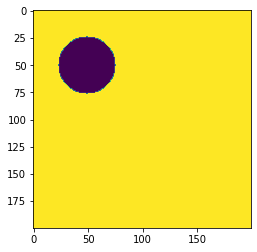

In [2]:
IMAGE_SIZE = 200;
rad = random.randint(5,50);
c_x = random.randint(rad,IMAGE_SIZE-rad); 
# Image_size - rad를 통해서 원이 잘리지 않게 설정해주기
c_y = random.randint(rad,IMAGE_SIZE-rad);
# 크기도 5~50, 위치도 랜덤하게 원을 그린다.
blank_image = np.ones(shape=[IMAGE_SIZE, IMAGE_SIZE], dtype=np.uint8)
cv2.circle(blank_image, (c_x,c_y), rad, 0, -1);
plt.imshow(blank_image);

In [3]:
def create_training_Data():
  l = 10000;
  X_train = np.zeros(shape=[l,IMAGE_SIZE, IMAGE_SIZE,1]);
  Y_train = np.zeros(shape = [l,3]);
  for i in range(l): # 10,000개 생성한다.
    rad = random.randint(5,50);
    c_x = random.randint(rad,IMAGE_SIZE-rad);
    c_y = random.randint(rad,IMAGE_SIZE-rad);
    Y_train[i,0]= c_x/IMAGE_SIZE;
    Y_train[i,1] = c_y/IMAGE_SIZE;
    Y_train[i,2] = rad/IMAGE_SIZE;
    blank_image = np.ones(shape=[IMAGE_SIZE, IMAGE_SIZE], dtype=np.uint8);
    X_train[i,:,:,0] = cv2.circle(blank_image, (c_x,c_y), rad, 0, -1);
  return {'X_Train' : X_train, 'Y_Train': Y_train};
  

In [4]:
training_Data = create_training_Data();

array([25., 85., 25.])

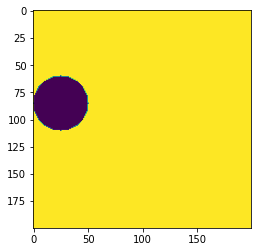

In [5]:
plt.imshow(training_Data['X_Train'][1999].reshape(200,200))
IMAGE_SIZE*training_Data['Y_Train'][1999]

In [6]:
import tensorflow
from tensorflow.keras import layers
from tensorflow.keras import Model

Conv 필터는 이미지의 특정 패턴을 잡아내는데 사용됩니다. 초반에 위치한 Layer들은 주로 사물을 구성하는 edge나 corner와 같은 좀 더 상세한 패턴을 잡아냅니다.

x = Input(shape=(28, 28, 3)) 

Conv2D(filters=32, kernel_size =(3, 3))

먼저 3차원 Conv 필터를 만듭니다. 이때 하나의 3차원 Conv 필터는 가로와 세로가 3x3(kernel_size=(3,3) 이므로) 이고 채널수(깊이)가 3인 3x3x3 필터가 됩니다.채널수가 3인 이유는 Input shape가 28x28x3 으로 Input의 채널수가 3이기 때문에 이와 동일한 채널수를 반드시 가져야 하기 때문입니다. 

다음으로 Conv2D()의 filters=32 이므로 이러한 3차원 Conv 필터를 32개를 만들게 됩니다. 즉 형태가 3x3x3인 3차원 Conv 필터를 32개를 가지게 되므로 parameter 수는 3x3x3x32 가 됩니다(bias 까지 생각하면 3x3x3x32 + 32) 

In [7]:
img_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 1)) # RGB파일 아니라서 channel이 1개로 입력

x = layers.Conv2D(5,3,activation='relu', strides=1, padding="same")(img_input)
                  # filter 개수 =5, filter kernel 크기=3
x = layers.MaxPool2D(pool_size=2)(x) # maxpooling을 통해서 (output shape)크기가 줄어들었다.
x = layers.Conv2D(10,3,activation='relu', strides=1)(x) # padding을 안했기 때문에 100->98로 2만큼 줄어들었다.
x = layers.MaxPool2D(pool_size=2)(x)
x = layers.Conv2D(20,3,activation='relu', strides=1)(x)
x = layers.MaxPool2D(pool_size=2)(x)
x = layers.Conv2D(3,5,activation='relu', strides=1)(x)
                  # 커널의 크기가 5이니까 (output shape)크기가 4만큼 줄어든다.
x = layers.Flatten()(x)
output= layers.Dense(3, activation='relu')(x)
# classfication이 아니라서 relu를 통해서 진행해도 된다.
# output => 3개
model = Model(img_input, output)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 200, 200, 5)       50        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 100, 100, 5)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 98, 98, 10)        460       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 49, 49, 10)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 47, 47, 20)        1820  

In [8]:
model.compile(loss='mean_squared_error',optimizer= 'adam', metrics=['mse']);

In [10]:
model.fit(training_Data["X_Train"],training_Data["Y_Train"], epochs = 10,verbose=1)

Epoch 1/10
313/313 [==============================] - 4s 14ms/step - loss: 0.0012 - mse: 0.0012
Epoch 2/10
313/313 [==============================] - 4s 13ms/step - loss: 9.4563e-04 - mse: 9.4563e-04
Epoch 3/10
313/313 [==============================] - 4s 13ms/step - loss: 8.0610e-04 - mse: 8.0610e-04
Epoch 4/10
313/313 [==============================] - 4s 13ms/step - loss: 6.9545e-04 - mse: 6.9545e-04
Epoch 5/10
313/313 [==============================] - 4s 13ms/step - loss: 6.1464e-04 - mse: 6.1464e-04
Epoch 6/10
313/313 [==============================] - 4s 13ms/step - loss: 5.4851e-04 - mse: 5.4851e-04
Epoch 7/10
313/313 [==============================] - 4s 13ms/step - loss: 4.9015e-04 - mse: 4.9015e-04
Epoch 8/10
313/313 [==============================] - 4s 13ms/step - loss: 4.6169e-04 - mse: 4.6169e-04
Epoch 9/10
313/313 [==============================] - 4s 13ms/step - loss: 4.2333e-04 - mse: 4.2333e-04
Epoch 10/10
313/313 [==============================] - 4s 13ms/step - lo

#### 결과값의 유사도를 확인해보자

In [11]:
IMAGE_SIZE*model.predict(training_Data['X_Train'][3].reshape(1,IMAGE_SIZE, IMAGE_SIZE,1))

array([[108.262085, 126.249146,  29.850716]], dtype=float32)

In [12]:
IMAGE_SIZE*training_Data['Y_Train'][3]

array([112., 119.,  31.])

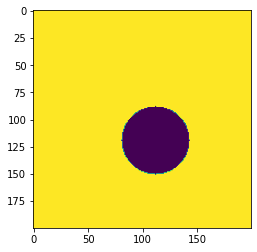

In [13]:
plt.imshow(training_Data['X_Train'][3].reshape(200,200))

[34, 137, 24]
[[ 25.263382 146.52246   27.552986]]


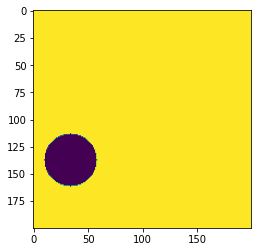

In [14]:
IMAGE_SIZE = 200;
# 랜덤한 그림을 하나 만들어서 진행
rad = random.randint(5,50);
c_x = random.randint(rad,IMAGE_SIZE-rad);
c_y = random.randint(rad,IMAGE_SIZE-rad);
print([c_x, c_y, rad]) # 랜덤 도형(원) 위치 출력

blank_image = np.ones(shape=[IMAGE_SIZE, IMAGE_SIZE], dtype=np.uint8)
new_Image = cv2.circle(blank_image, (c_x,c_y), rad, 0, -1);
plt.imshow(new_Image);
print(IMAGE_SIZE*model.predict(new_Image.reshape(1,IMAGE_SIZE, IMAGE_SIZE,1)))